In [1]:
import numpy as np
from catboost import CatBoostClassifier, datasets
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt

In [44]:
positive_steps = [500, 1250, 2500, 5000, 7841]
negative_steps = [2500, 5000, 10000, 20000, 24720]
categorical_features = [
    'workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country',
]
df = pd.read_csv('adult/adult.data')
assert df.shape[0] == (positive_steps[-1] + negative_steps[-1])

# Catboost

In [45]:
catboost_scores = np.zeros(shape=(len(negative_steps), len(positive_steps)))
catboost_means = np.zeros(shape=(len(negative_steps), len(positive_steps)))
for i, positive in enumerate(tqdm(positive_steps)):
    for j, negative in enumerate(tqdm(negative_steps, leave=False)):
        train_df = pd.read_csv('adult/adult.data')
        train_df = (
            pd
            .concat([train_df[train_df.label != ' <=50K'][:positive], train_df[train_df.label == ' <=50K'][:negative]])
            .sample(frac=1)
            .reset_index(drop=True)
        )
        y = df.label.apply(lambda x: 0 if x.strip() == '<=50K' else 1)
        X = df.drop(columns=['label'])
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25)

        params = {'loss_function':'Logloss',
                  'eval_metric':'AUC',
                  'cat_features': categorical_features,
                  'early_stopping_rounds': 200,
                  'verbose': False,  # 200, # output to stdout info about training process every 200 iterations
                 }
        cbc_1 = CatBoostClassifier(**params)
        cbc_1.fit(
            X_train, y_train,
            eval_set=(X_valid, y_valid),
            use_best_model=True,
            plot=False,
        )
        catboost_scores[j, i] = accuracy_score(y_valid, cbc_1.predict(X_valid))
        catboost_means[j, i] = cbc_1.predict(X_valid).mean()

## Keras

In [46]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

In [100]:
keras_scores = np.zeros(shape=(len(negative_steps), len(positive_steps)))
keras_means = np.zeros(shape=(len(negative_steps), len(positive_steps)))
for i, positive in enumerate(tqdm(positive_steps)):
    for j, negative in enumerate(tqdm(negative_steps, leave=False)):
        train_df = pd.read_csv('adult/adult.data')
        train_df = (
            pd
            .concat([train_df[train_df.label != ' <=50K'][:positive], train_df[train_df.label == ' <=50K'][:negative]])
            .sample(frac=1)
            .reset_index(drop=True)
        )
        y = df.label.apply(lambda x: 0 if x.strip() == '<=50K' else 1)
        X = df.drop(columns=['label'])
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25)

        for col in X.columns:
            if col not in categorical_features:
                X[col] = (X[col] - X[col].min()) / (X[col].max() - X[col].min())
        X = pd.get_dummies(X, columns=categorical_features)

        X = X.astype('float32')
        y = y.astype('float32')
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25)
        
        model = keras.Sequential([
            keras.layers.Dense(256, activation='relu'),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(128, activation='relu'),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(1, activation='sigmoid'),
        ])
        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor="val_loss",
                min_delta=0,
                patience=0,
                verbose=0,
                mode="auto",
                baseline=None,
                restore_best_weights=False,
            )
        ]
        model.fit(
            X_train, y_train,
            epochs=15, validation_data=(X_valid, y_valid),
            callbacks=callbacks, verbose=False,
        )

        test_loss, test_acc = model.evaluate(X_valid,  y_valid, verbose=0)
        
        keras_scores[j, i] = test_acc
        keras_means[j, i] = (model.predict(X_valid) > 0.5).mean()

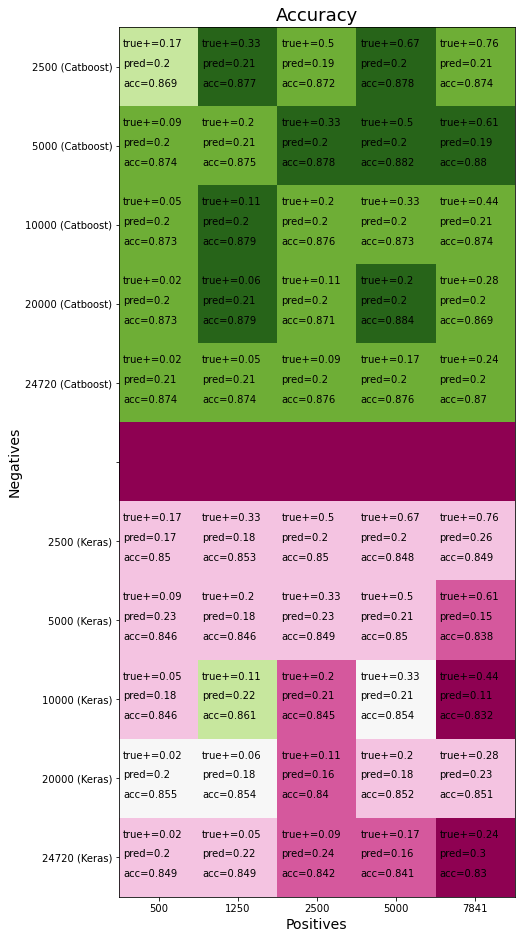

In [101]:
cmap = np.concatenate([
    catboost_scores,
    np.full((1, len(positive_steps)), min(catboost_scores.min(), keras_scores.min())),
    keras_scores
])
plt.figure(figsize=(12, 16))
plt.title(f'Accuracy', fontsize=18)
plt.imshow(cmap, cmap=plt.get_cmap("PiYG", 7))
plt.xlabel('Positives', fontsize=14)
plt.ylabel('Negatives', fontsize=14)
plt.xticks(range(len(positive_steps)), positive_steps)
plt.yticks(
    range(len(negative_steps)*2+1),
    [f'{x} (Catboost)' for x in negative_steps] + [''] + [f'{x} (Keras)' for x in negative_steps]
)
for i in range(len(negative_steps)):
    for j in range(len(positive_steps)):
        plt.text(j-0.45, i-0.25, f'true+={round(positive_steps[j] / (positive_steps[j] + negative_steps[i]), 2)}')
        plt.text(j-0.45, i, f'pred={round(catboost_means[i, j], 2)}')
        plt.text(j-0.45, i+0.25, f'acc={round(catboost_scores[i, j], 3)}')
        plt.text(j-0.45, i-0.25 + len(negative_steps) + 1, f'true+={round(positive_steps[j] / (positive_steps[j] + negative_steps[i]), 2)}')
        plt.text(j-0.45, i + len(negative_steps) + 1, f'pred={round(keras_means[i, j], 2)}')
        plt.text(j-0.45, i+0.25 + len(negative_steps) + 1, f'acc={round(keras_scores[i, j], 3)}')

In [97]:
keras_scores = np.zeros(shape=(len(negative_steps), len(positive_steps)))
keras_means = np.zeros(shape=(len(negative_steps), len(positive_steps)))
for i in [0]:
    for j in [0]:
        train_df = pd.read_csv('adult/adult.data')
        train_df = train_df.sample(frac=1).reset_index(drop=True)
        y = df.label.apply(lambda x: 0 if x.strip() == '<=50K' else 1)
        X = df.drop(columns=['label'])
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25)

        for col in X.columns:
            if col not in categorical_features:
                X[col] = (X[col] - X[col].min()) / (X[col].max() - X[col].min())
        X = pd.get_dummies(X, columns=categorical_features)

        X = X.astype('float32')
        y = y.astype('float32')
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25)
        
        model = keras.Sequential([
            keras.layers.Dense(256, activation='relu'),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(128, activation='relu'),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(1, activation='sigmoid'),
        ])
        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        history = model.fit(X_train, y_train, epochs=15, validation_data=(X_valid, y_valid), verbose=False)

        test_loss, test_acc = model.evaluate(X_valid,  y_valid, verbose=False)
        print(f'loss={test_loss}, acc={test_acc}')

loss=0.3453872799873352, acc=0.8478074073791504


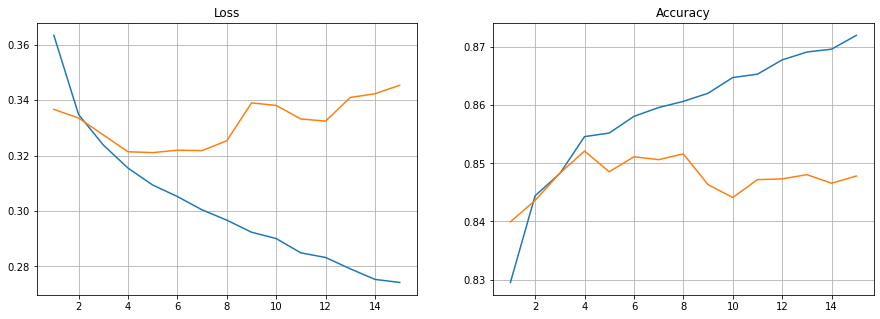

In [98]:
epochs = list(range(1, len(history.history['loss']) + 1))
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.title('Loss')
plt.grid(True)
plt.plot(epochs, history.history['loss'], label='train')
plt.plot(epochs, history.history['val_loss'], label='validation')
plt.subplot(122)
plt.title('Accuracy')
plt.grid(True)
plt.plot(epochs, history.history['accuracy'], label='train')
plt.plot(epochs, history.history['val_accuracy'], label='validation')